In [1]:
import xgboost
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('mode.chained_assignment', None)

In [2]:
from fastai.imports import *
from fastai.structured import *

### Load samples

In [3]:
samples = pd.read_pickle('Utah/03_dense_samples.pkl')
samples.shape

(1230745, 58)

In [4]:
samples.tail()

,DATE,CRASHID,RouteName,BeginMilePost,CrashSeverity,MANNERCOLLISIONID,ROADWAYJUNCTFEATUREID,NUMBERVEHICLESINVOLVED,FIRSTHARMFULEVENTID,ROADWAYTYPECD,ROUTEDIRECTION,EXITNUMBER,RAMPID,Latitude,Longitude,lat,lon,year,incident,LABEL,AVG_AADT,AvE_CRT,AvE_SEV_CR,BEG_MP,CRT,C_MI,DESCRIP,END_MP,EXP_CRT,EXP_SEV_CR,FC_NAME,OBJECTID,PROTECTED,REGION,RouteNm,SAF_INDEX,SEV_CRT,SEV_C_MI,State_FA,TOT_C,TOT_SEV_C,SHAPE,weatherstn_index,Station ID,Station Name,target,key,precip_accum_set_1,wind_gust_set_1,wind_direction_set_1,relative_humidity_set_1,dew_point_temperature_set_1d,wind_speed_set_1,air_temp_set_1,num_crashes,crash_density,length,curvature
1230740,2010-03-31 15:10:00,10345417,0150P,29.04,1,Single Vehicle,No Special Feature/Junction,1,Tree/Shrubbery,Mainline,P,NaN,NaN,4504044.0,507872.0,40.68725,-110.906838,2010,0,0150P,555.0,0.0,0.0,29.018,0.0,0.0,Bald Mountain Overlook via SR 150 - Hayden Pea...,30.019,1.86,10.4,Rural Major Collector,2084,23 USC 409,2,SR-150,0.0,0.0,0.0,State,0,0,"{'paths': [[[-12346095.4461, 4966275.149999998...",3033,TRLU1,TRIAL LAKE,0,20109015TRLU1,304.80,NaN,NaN,NaN,NaN,NaN,-3.3,1,0.4711,2122.691809,1.465262
1230741,2010-08-01 17:44:00,10353526,0150P,29.04,1,Single Vehicle,No Special Feature/Junction,1,Tree/Shrubbery,Mainline,P,NaN,NaN,4504044.0,507872.0,40.68725,-110.906838,2010,1,0150P,555.0,0.0,0.0,29.018,0.0,0.0,Bald Mountain Overlook via SR 150 - Hayden Pea...,30.019,1.86,10.4,Rural Major Collector,2084,23 USC 409,2,SR-150,0.0,0.0,0.0,State,0,0,"{'paths': [[[-12346095.4461, 4966275.149999998...",3033,TRLU1,TRIAL LAKE,1,201021317TRLU1,718.82,NaN,NaN,NaN,NaN,NaN,15.3,1,0.4711,2122.691809,1.465262
1230742,2010-12-31 23:15:00,10408642,0150P,29.04,1,Single Vehicle,No Special Feature/Junction,1,Tree/Shrubbery,Mainline,P,NaN,NaN,4504044.0,507872.0,40.68725,-110.906838,2010,0,0150P,555.0,0.0,0.0,29.018,0.0,0.0,Bald Mountain Overlook via SR 150 - Hayden Pea...,30.019,1.86,10.4,Rural Major Collector,2084,23 USC 409,2,SR-150,0.0,0.0,0.0,State,0,0,"{'paths': [[[-12346095.4461, 4966275.149999998...",3033,TRLU1,TRIAL LAKE,0,201036523TRLU1,490.22,NaN,NaN,NaN,NaN,NaN,-20.6,1,0.4711,2122.691809,1.465262
1230743,2010-12-19 17:27:00,10407428,0150P,29.04,1,Single Vehicle,No Special Feature/Junction,1,Tree/Shrubbery,Mainline,P,NaN,NaN,4504044.0,507872.0,40.68725,-110.906838,2010,0,0150P,555.0,0.0,0.0,29.018,0.0,0.0,Bald Mountain Overlook via SR 150 - Hayden Pea...,30.019,1.86,10.4,Rural Major Collector,2084,23 USC 409,2,SR-150,0.0,0.0,0.0,State,0,0,"{'paths': [[[-12346095.4461, 4966275.149999998...",3033,TRLU1,TRIAL LAKE,0,201035317TRLU1,403.86,NaN,NaN,NaN,NaN,NaN,-1.3,1,0.4711,2122.691809,1.465262
1230744,2010-08-01 22:44:00,10353526,0150P,29.04,1,Single Vehicle,No Special Feature/Junction,1,Tree/Shrubbery,Mainline,P,NaN,NaN,4504044.0,507872.0,40.68725,-110.906838,2010,0,0150P,555.0,0.0,0.0,29.018,0.0,0.0,Bald Mountain Overlook via SR 150 - Hayden Pea...,30.019,1.86,10.4,Rural Major Collector,2084,23 USC 409,2,SR-150,0.0,0.0,0.0,State,0,0,"{'paths': [[[-12346095.4461, 4966275.149999998...",3033,TRLU1,TRIAL LAKE,0,201021322TRLU1,716.28,NaN,NaN,NaN,NaN,NaN,18.0,1,0.4711,2122.691809,1.465262


In [5]:
samples.drop(columns='SHAPE', inplace=True)

In [6]:
samples.describe(include='all').transpose()

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
DATE,1230745,800784,2013-01-24 07:30:00,22,2010-01-01 00:05:00,2017-12-31 23:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CRASHID,1.23074e+06,NaN,NaN,NaN,NaN,NaN,1.06677e+07,198513,1.03088e+07,1.05051e+07,1.06511e+07,1.08437e+07,1.10256e+07
RouteName,1230745,881,0015P,108357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginMilePost,1.23074e+06,NaN,NaN,NaN,NaN,NaN,86.8372,130.764,0,2.54,9.808,126.6,502.56
CrashSeverity,1.23074e+06,NaN,NaN,NaN,NaN,NaN,1.47498,0.801439,1,1,1,2,5
MANNERCOLLISIONID,1230745,11,Front to Rear,418598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROADWAYJUNCTFEATUREID,1230745,20,No Special Feature/Junction,601416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NUMBERVEHICLESINVOLVED,1.23074e+06,NaN,NaN,NaN,NaN,NaN,1.85972,0.659671,1,1,2,2,16
FIRSTHARMFULEVENTID,1230745,53,Other Motor Vehicle in Transport,868957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROADWAYTYPECD,1230745,2,Mainline,1230600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
samples.columns

Index(['DATE', 'CRASHID', 'RouteName', 'BeginMilePost', 'CrashSeverity', 'MANNERCOLLISIONID', 'ROADWAYJUNCTFEATUREID', 'NUMBERVEHICLESINVOLVED', 'FIRSTHARMFULEVENTID', 'ROADWAYTYPECD', 'ROUTEDIRECTION', 'EXITNUMBER', 'RAMPID', 'Latitude', 'Longitude', 'lat', 'lon', 'year', 'incident', 'LABEL', 'AVG_AADT', 'AvE_CRT', 'AvE_SEV_CR', 'BEG_MP', 'CRT', 'C_MI', 'DESCRIP', 'END_MP', 'EXP_CRT', 'EXP_SEV_CR', 'FC_NAME', 'OBJECTID', 'PROTECTED', 'REGION', 'RouteNm', 'SAF_INDEX', 'SEV_CRT', 'SEV_C_MI', 'State_FA', 'TOT_C', 'TOT_SEV_C', 'weatherstn_index', 'Station ID', 'Station Name', 'target', 'key', 'precip_accum_set_1', 'wind_gust_set_1', 'wind_direction_set_1', 'relative_humidity_set_1', 'dew_point_temperature_set_1d', 'wind_speed_set_1', 'air_temp_set_1', 'num_crashes', 'crash_density', 'length', 'curvature'], dtype='object')

### Add date parts

In [8]:
for datepart in ('hour', 'month', 'week', 'day', 'dayofweek', 'dayofyear', 'is_month_end', 'is_month_start'):
    samples[datepart] = getattr(samples['DATE'].dt, datepart)
samples['elapsed'] = samples['DATE'].astype(np.int64)

In [9]:
samples[:3]['DATE'].astype(np.int64)

0    1333529100000000000
1    1342166640000000000
2    1331044920000000000
Name: DATE, dtype: int64

In [10]:
samples.columns

Index(['DATE', 'CRASHID', 'RouteName', 'BeginMilePost', 'CrashSeverity', 'MANNERCOLLISIONID', 'ROADWAYJUNCTFEATUREID', 'NUMBERVEHICLESINVOLVED', 'FIRSTHARMFULEVENTID', 'ROADWAYTYPECD', 'ROUTEDIRECTION', 'EXITNUMBER', 'RAMPID', 'Latitude', 'Longitude', 'lat', 'lon', 'year', 'incident', 'LABEL', 'AVG_AADT', 'AvE_CRT', 'AvE_SEV_CR', 'BEG_MP', 'CRT', 'C_MI', 'DESCRIP', 'END_MP', 'EXP_CRT', 'EXP_SEV_CR', 'FC_NAME', 'OBJECTID', 'PROTECTED', 'REGION', 'RouteNm', 'SAF_INDEX', 'SEV_CRT', 'SEV_C_MI', 'State_FA', 'TOT_C', 'TOT_SEV_C', 'weatherstn_index', 'Station ID', 'Station Name', 'target', 'key', 'precip_accum_set_1', 'wind_gust_set_1', 'wind_direction_set_1', 'relative_humidity_set_1', 'dew_point_temperature_set_1d', 'wind_speed_set_1', 'air_temp_set_1', 'num_crashes', 'crash_density', 'length', 'curvature', 'hour', 'month', 'week', 'day', 'dayofweek', 'dayofyear', 'is_month_end', 'is_month_start', 'elapsed'], dtype='object')

In [11]:
samples.dtypes

DATE                            datetime64[ns]
CRASHID                                  int64
RouteName                               object
BeginMilePost                          float64
CrashSeverity                            int64
MANNERCOLLISIONID                       object
ROADWAYJUNCTFEATUREID                   object
NUMBERVEHICLESINVOLVED                   int64
FIRSTHARMFULEVENTID                     object
ROADWAYTYPECD                           object
ROUTEDIRECTION                          object
EXITNUMBER                             float64
RAMPID                                  object
Latitude                               float64
Longitude                              float64
lat                                    float64
lon                                    float64
year                                     int64
incident                                 int64
LABEL                                   object
AVG_AADT                               float64
AvE_CRT      

### Filter columns to those available at prediction time

In [12]:
columns = [
     # categorical - strings
    'RouteName', 'ROADWAYTYPECD', 'ROUTEDIRECTION', 'FC_NAME', 'State_FA', 
    
     # enriched from Safety Index layer
    'AVG_AADT', 'AvE_CRT', 'AvE_SEV_CR', 'CRT', 'C_MI', 'EXP_CRT', 'EXP_SEV_CR', 
    'REGION', 'SAF_INDEX', 'SEV_CRT', 'SEV_C_MI',  'TOT_C', 'TOT_SEV_C', 
    
     # weather features - continuous
    'precip_accum_set_1', 'wind_gust_set_1', 'wind_direction_set_1', 'relative_humidity_set_1', 
    'dew_point_temperature_set_1d', 'wind_speed_set_1', 'air_temp_set_1', 
    
     # computed crash density, curvature, length...
    'num_crashes', 'crash_density', 'length', 'curvature', 
    
     # time related
    'year', 'hour', 'month', 'week', 'day', 'dayofweek', 'dayofyear', 'is_month_end', 'is_month_start', 'elapsed',
     
     # location
    'lat', 'lon', 
    
    'target']

In [13]:
df = samples[columns]

### Convert strings to categorical columns

In [14]:
for name, series in df.items():
    if is_string_dtype(series): 
        df[name] = series.astype('category').cat.as_ordered()

### Handle null values

In [15]:
df.isnull().sum().sort_values()

RouteName                             0
crash_density                         0
length                                0
curvature                             0
year                                  0
hour                                  0
month                                 0
num_crashes                           0
week                                  0
dayofweek                             0
dayofyear                             0
is_month_end                          0
is_month_start                        0
elapsed                               0
lat                                   0
day                                   0
lon                                   0
target                                0
EXP_SEV_CR                            0
AvE_CRT                               0
AvE_SEV_CR                            0
CRT                                   0
C_MI                                  0
EXP_CRT                               0
TOT_SEV_C                             0


In [16]:
y = df['target'].values

In [17]:
X = df.drop('target', axis=1)

### Fill missing values with median

In [18]:
def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [19]:
na_dict = {}

for name, col in X.items():
    na_dict = fix_missing(X, col, name, na_dict)

In [20]:
def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

### Change columns from categorical types to integer codes

In [21]:
def numericalize(df, col, name, ):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes + 1

In [22]:
for name, col in df.items(): 
    numericalize(X, col, name)

In [23]:
X.head()

,RouteName,ROADWAYTYPECD,ROUTEDIRECTION,FC_NAME,State_FA,AVG_AADT,AvE_CRT,AvE_SEV_CR,CRT,C_MI,EXP_CRT,EXP_SEV_CR,REGION,SAF_INDEX,SEV_CRT,SEV_C_MI,TOT_C,TOT_SEV_C,precip_accum_set_1,wind_gust_set_1,wind_direction_set_1,relative_humidity_set_1,dew_point_temperature_set_1d,wind_speed_set_1,air_temp_set_1,num_crashes,crash_density,length,curvature,year,hour,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,elapsed,lat,lon,precip_accum_set_1_na,wind_gust_set_1_na,wind_direction_set_1_na,relative_humidity_set_1_na,dew_point_temperature_set_1d_na,wind_speed_set_1_na,air_temp_set_1_na
0,85,2,2,12,2,19431.666667,0.866633,1.818762,2.374576,16.842105,2.74,6.8,3,7.0,12.367582,0.877193,96,5,0.000,1.38,190.525,56.2,-3.58,0.67,5.56,281,70.398978,3991.535236,1.028323,2012,8,4,14,4,2,95,False,False,1333529100000000000,40.207732,-111.629724,False,False,False,False,False,False,False
1,85,2,2,12,2,19431.666667,0.866633,1.818762,2.374576,16.842105,2.74,6.8,3,7.0,12.367582,0.877193,96,5,14.986,4.34,98.700,34.2,4.44,2.33,23.33,281,70.398978,3991.535236,1.028323,2012,8,7,28,13,4,195,False,False,1342166640000000000,40.199805,-111.619558,False,False,False,False,False,False,False
2,85,2,2,12,2,19431.666667,0.866633,1.818762,2.374576,16.842105,2.74,6.8,3,7.0,12.367582,0.877193,96,5,2.032,8.36,164.300,20.1,-12.85,3.13,9.78,281,70.398978,3991.535236,1.028323,2012,14,3,10,6,1,66,False,False,1331044920000000000,40.188876,-111.611188,False,False,False,False,False,False,False
3,85,2,2,12,2,19431.666667,0.866633,1.818762,2.374576,16.842105,2.74,6.8,3,7.0,12.367582,0.877193,96,5,8.636,0.80,309.150,82.6,-6.66,0.00,-1.72,281,70.398978,3991.535236,1.028323,2012,6,12,49,6,3,341,False,False,1354775340000000000,40.191546,-111.612187,False,False,False,False,False,False,False
4,85,2,2,12,2,19431.666667,0.866633,1.818762,2.374576,16.842105,2.74,6.8,3,7.0,12.367582,0.877193,96,5,153.670,4.47,247.500,56.0,-1.04,5.32,1.50,281,70.398978,3991.535236,1.028323,2012,7,1,1,7,5,7,False,False,1325919600000000000,40.187256,-111.610739,True,True,False,True,True,False,False


In [24]:
X.shape

(1230745, 48)

In [25]:
X = pd.get_dummies(X, dummy_na=True)

In [26]:
X.shape

(1230745, 48)

# Apply machine learning

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### GaussianNB

In [29]:
from sklearn.naive_bayes import GaussianNB
nbclf = GaussianNB().fit(X_train, y_train)
print('Accuracy of GaussianNB classifier on training set: {:.2f}'
     .format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(nbclf.score(X_test, y_test)))

Accuracy of GaussianNB classifier on training set: 0.75
Accuracy of GaussianNB classifier on test set: 0.75


### DecisionTreeClassifier

In [30]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
dlf = model.fit(X_train,y_train)
print('Accuracy of GaussianNB classifier on training set: {:.2f}'
     .format(dlf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(dlf.score(X_test, y_test)))

Accuracy of GaussianNB classifier on training set: 1.00
Accuracy of GaussianNB classifier on test set: 0.63


### GradientBoostingClassifier

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier().fit(X_train, y_train)

print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of RF classifier on training set: 0.75
Accuracy of RF classifier on test set: 0.75


### MLPClassifier

In [33]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
mlp = model.fit(X_train,y_train)
print('Accuracy of GaussianNB classifier on training set: {:.2f}'
     .format(mlp.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(mlp.score(X_test, y_test)))

Accuracy of GaussianNB classifier on training set: 0.75
Accuracy of GaussianNB classifier on test set: 0.75


# RandomForestClassifier

### Base model

In [31]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
rfc = model.fit(X_train,y_train)
print('Accuracy of GaussianNB classifier on training set: {:.2f}'
     .format(rfc.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(rfc.score(X_test, y_test)))

Accuracy of GaussianNB classifier on training set: 0.97
Accuracy of GaussianNB classifier on test set: 0.72


In [93]:
def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [94]:
m = RandomForestClassifier(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2min 28s, sys: 896 ms, total: 2min 29s
Wall time: 27.9 s
[0.9729574363495281, 0.7231514245436707]


In [95]:
m = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.7494769428273119, 0.7494972557272221]


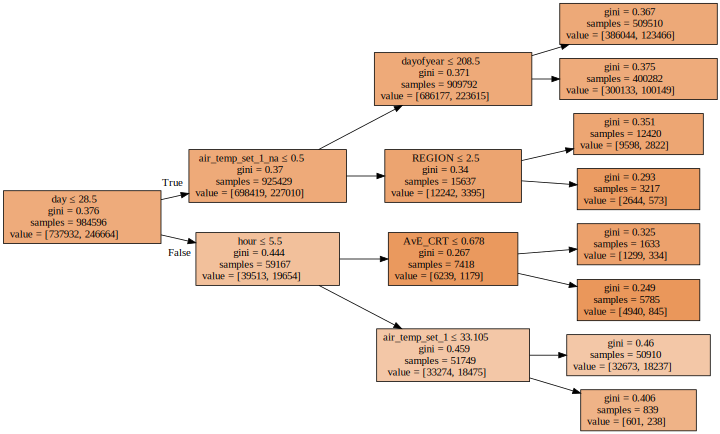

In [97]:
draw_tree(m.estimators_[0], X_train, precision=3)

In [98]:
m = RandomForestClassifier(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.0, 0.6222044371498564]


### Bagging

In [100]:
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.9734053357925484, 0.724028941819792]


In [101]:
preds = np.stack([t.predict(X_test) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_test[0]

(array([0., 0., 1., 0., 0., 1., 1., 0., 0., 0.]), 0.3, 1)

In [102]:
preds.shape

(10, 246149)

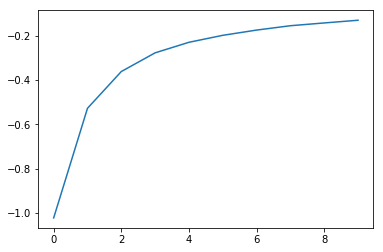

In [103]:
plt.plot([metrics.r2_score(y_test, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [104]:
m = RandomForestClassifier(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.992930095186249, 0.7326212984818139]


In [105]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.9991488894937619, 0.7377360866792065]


In [106]:
m = RandomForestClassifier(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.9999695306501347, 0.7402955120678938]


Adding more trees isn't helping with generalization. Try subsampling

## Reduce over fitting

### Out of bag (OOB) score

In [107]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9991539677187394, 0.7372526396613434, 0.7223470337072261]


### Subsampling

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [109]:
# Changes Scikit learn's random forests to give each tree a random sample of n random rows.
from sklearn.ensemble import forest

n = 20000
forest._generate_sample_indices = (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples, n))

In [111]:
m = RandomForestClassifier(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 9.09 s, sys: 444 ms, total: 9.53 s
Wall time: 7.06 s
[0.7392047093427152, 0.7344982104335179, 0.7314380720620437]


Adding more trees with subsampling is helping increate accuracy by 1.5%:

In [112]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.7494464734774466, 0.7483719210721961, 0.7479910541988796]


### Tree building paramaters

In [113]:
# reset subsampling
forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [114]:
# baseline model:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9991326391738338, 0.7378173382788473, 0.7233129120979569]


Grow trees less deeply by specifying `min_Samples_leaf=3`

In [115]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9132689956083511, 0.7482297307728246, 0.7378945272985062]


Try specifying max_features, which is the proportion of features to randomly select from at each split.

In [116]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9627045001198461, 0.7485913003912265, 0.7361719933861198]


### Combine subsampling with tree building parameters.

In [117]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9733281467728896, 0.7519266785564841, 0.7475218262109535]


In [ ]:
# try layer:
n = 20000
forest._generate_sample_indices = (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples, n))

m = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

# XGBoost

In [122]:
feature_name = list(X_train.columns)

dtrain = xgboost.DMatrix(X_train, label=y_train)
dvalid = xgboost.DMatrix(X_test, label=y_test)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [129]:
md = [6]
lr = [0.1,0.3]
mcw = [20,25,30]
for m in md:
   for l in lr:
       for n in mcw:
           xgb_pars = {'min_child_weight': n, 'eta': l, 'colsample_bytree': 0.9, 
                       'max_depth': m,
           'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
           'eval_metric': 'rmse',  'objective':'binary:logistic'}
           model = xgboost.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10,
                 maximize=False, verbose_eval=1)

[0]	train-rmse:0.487381	valid-rmse:0.487396
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.476841	valid-rmse:0.476871
[2]	train-rmse:0.468125	valid-rmse:0.468165
[3]	train-rmse:0.460935	valid-rmse:0.46098
[4]	train-rmse:0.455275	valid-rmse:0.455326
[5]	train-rmse:0.450374	valid-rmse:0.450434
[6]	train-rmse:0.446326	valid-rmse:0.446392
[7]	train-rmse:0.443048	valid-rmse:0.443128
[8]	train-rmse:0.440307	valid-rmse:0.440406
[9]	train-rmse:0.438059	valid-rmse:0.438166
[10]	train-rmse:0.43621	valid-rmse:0.436321
[11]	train-rmse:0.434712	valid-rmse:0.434832
[12]	train-rmse:0.433497	valid-rmse:0.433625
[13]	train-rmse:0.432444	valid-rmse:0.432583
[14]	train-rmse:0.431587	valid-rmse:0.431738
[15]	train-rmse:0.430904	valid-rmse:0.431065
[16]	train-rmse:0.43032	valid-rmse:0.430495
[17]	train-rmse:0.429859	valid-rmse:0.430046
[18]	train-rmse:0.429462	valid-rmse:0.429661
[19]	train-rm

[21]	train-rmse:0.426278	valid-rmse:0.427007
[22]	train-rmse:0.426197	valid-rmse:0.42697
[23]	train-rmse:0.426131	valid-rmse:0.426967
[24]	train-rmse:0.426057	valid-rmse:0.426962
[25]	train-rmse:0.426036	valid-rmse:0.426962
[26]	train-rmse:0.425964	valid-rmse:0.426945
[27]	train-rmse:0.425894	valid-rmse:0.426908
[28]	train-rmse:0.425868	valid-rmse:0.426917
[29]	train-rmse:0.42576	valid-rmse:0.426859
[30]	train-rmse:0.42572	valid-rmse:0.426842
[31]	train-rmse:0.425683	valid-rmse:0.426831
[32]	train-rmse:0.425631	valid-rmse:0.426842
[33]	train-rmse:0.425582	valid-rmse:0.426832
[34]	train-rmse:0.425544	valid-rmse:0.426847
[35]	train-rmse:0.425484	valid-rmse:0.426835
[36]	train-rmse:0.425422	valid-rmse:0.426818
[37]	train-rmse:0.425409	valid-rmse:0.426824
[38]	train-rmse:0.425262	valid-rmse:0.426727
[39]	train-rmse:0.425171	valid-rmse:0.426693
[40]	train-rmse:0.425106	valid-rmse:0.426673
[41]	train-rmse:0.425069	valid-rmse:0.426669
[42]	train-rmse:0.425006	valid-rmse:0.426649
[43]	train-rm

In [133]:
y_pred_test = np.round(model.predict(dvalid))
print('\n\nTest Accuracy:', accuracy_score(y_test, y_pred_test))
print('Test F1:', f1_score(y_test, y_pred_test))
print('Test Precision:', precision_score(y_test, y_pred_test))
print('Test Recall:', recall_score(y_test, y_pred_test))
y_pred_test = model.predict(dvalid)
print('Test AUC:', roc_auc_score(y_test, y_pred_test))

y_pred_train = np.round(model.predict(dtrain))
print('\nTrain Accuracy:', accuracy_score(y_train, y_pred_train))
print('Train F1:', f1_score(y_train,y_pred_train))
print('Train Precision:', precision_score(y_train, y_pred_train))
print('Train Recall:', recall_score(y_train, y_pred_train))
y_pred_train = model.predict(dtrain)
print('Train AUC:', roc_auc_score(y_train, y_pred_train))



Test Accuracy: 0.7497369479461626
Test F1: 0.004878521581804084
Test Precision: 0.6213991769547325
Test Recall: 0.0024488736802841344
Test AUC: 0.6086125058443009

Train Accuracy: 0.7498253090607722
Train F1: 0.005402589851368212
Train Precision: 0.6723618090452261
Train Recall: 0.0027121914831511693
Train AUC: 0.6257521332995192


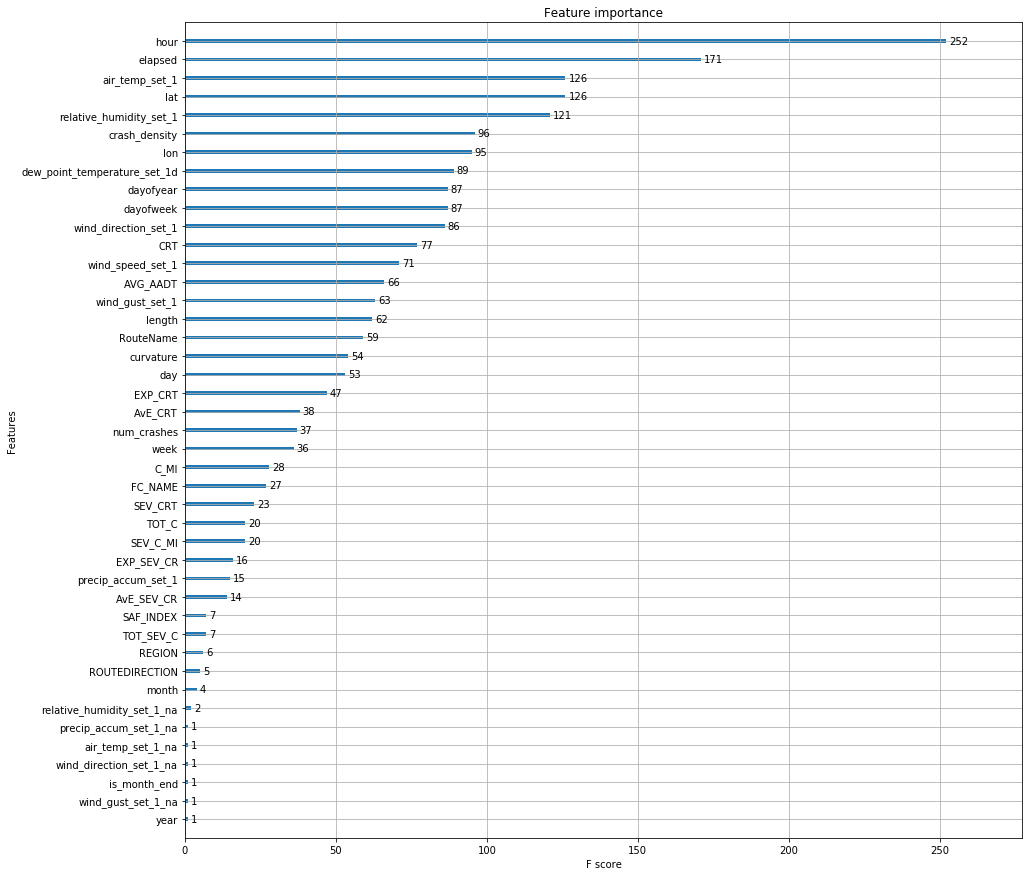

In [130]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(model, ax=plt.gca())

### Older model follows for reference

In [64]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

# X_train = xgboost.DMatrix(X_train, label=y_train, feature_names=feature_names)
# X_test =  xgboost.DMatrix(X_test, label=y_test, feature_names=feature_names)

In [52]:
params = {
    'max_depth':50,
    'n_estimators': 107,
    'objective':'binary:logistic',
    'lambda': 1.,
    'alpha': 0,
    'silent': 0
}
skf = StratifiedKFold(n_splits=3)

for train_index, test_index in skf.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    d_x_train = xgboost.DMatrix(X_train, label=y_train, feature_names=feature_names)
    d_x_test =  xgboost.DMatrix(X_test, label=y_test, feature_names=feature_names)
    
    booster = xgboost.train(params, d_x_train)
    
    y_pred_test = np.round(booster.predict(d_x_test))
    print('\n\nTest Accuracy:', accuracy_score(y_test, y_pred_test))
    print('Test F1:', f1_score(y_test, y_pred_test))
    print('Test Precision:', precision_score(y_test, y_pred_test))
    print('Test Recall:', recall_score(y_test, y_pred_test))
    y_pred_test = booster.predict(d_x_test)
    print('Test AUC:', roc_auc_score(y_test, y_pred_test))

    y_pred_train = np.round(booster.predict(d_x_train))
    print('\nTrain Accuracy:', accuracy_score(y_train, y_pred_train))
    print('Train F1:', f1_score(y_train,y_pred_train))
    print('Train Precision:', precision_score(y_train, y_pred_train))
    print('Train Recall:', recall_score(y_train, y_pred_train))
    y_pred_train = booster.predict(d_x_train)
    print('Train AUC:', roc_auc_score(y_train, y_pred_train))



Test Accuracy: 0.7237263223066966
Test F1: 0.1438531555689844
Test Precision: 0.321580547112462
Test Recall: 0.09264899051325712
Test AUC: 0.5689533893733264

Train Accuracy: 0.9960414188490864
Train F1: 0.9920384741716141
Train Precision: 0.9997282769796257
Train Recall: 0.98446606665045
Train AUC: 0.9999558985469252


Test Accuracy: 0.7242667849690919
Test F1: 0.1443278693484822
Test Precision: 0.3242251223491028
Test Recall: 0.09282413038190221
Test AUC: 0.5656438702688746

Train Accuracy: 0.9959049210417589
Train F1: 0.9917617578839487
Train Precision: 0.9997182458082885
Train Recall: 0.9839309170518122
Train AUC: 0.9999397398929096


Test Accuracy: 0.7245373530157369
Test F1: 0.12944874125658642
Test Precision: 0.3107593298073011
Test Recall: 0.08175139868645098
Test AUC: 0.5494724767668766

Train Accuracy: 0.9956453222863704
Train F1: 0.9912345046010878
Train Precision: 0.9997674084851365
Train Recall: 0.9828460228654828
Train AUC: 0.9998937742148102


In [44]:
continuous_features = [
    'AVG_AADT', 
     # safety index features
    'AvE_CRT', 'AvE_SEV_CR', 'CRT', 'C_MI', 'EXP_CRT', 'EXP_SEV_CR', 'SAF_INDEX', 'SEV_CRT', 'SEV_C_MI', 'TOT_C', 'TOT_SEV_C',
     # weather features
    'precip_accum_set_1', 'wind_gust_set_1', 'wind_direction_set_1', 'relative_humidity_set_1', 
    'dew_point_temperature_set_1d', 'wind_speed_set_1', 'air_temp_set_1',
     # crash density, curvature, road segment length
    'num_crashes', 'crash_density', 'length', 'curvature',
    'lat', 'lon'    
]

In [45]:
samples[continuous_features] = samples[continuous_features].fillna(-999)

In [67]:
samples['target'].value_counts(True)

0    0.749481
1    0.250519
Name: target, dtype: float64

In [5]:
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=samples['DATE'].min(), end=samples['DATE'].max()).to_pydatetime()

samples['is_holiday'] = samples['DATE'].isin(holidays)

In [6]:
holiday_eve = [(x - timedelta(days=1)) for x in holidays]
samples['is_holiday_eve'] = samples['DATE'].isin(holiday_eve)

In [8]:
samples.head(2)

,DATE,CRASHID,RouteName,BeginMilePost,CrashSeverity,MANNERCOLLISIONID,ROADWAYJUNCTFEATUREID,NUMBERVEHICLESINVOLVED,FIRSTHARMFULEVENTID,ROADWAYTYPECD,ROUTEDIRECTION,EXITNUMBER,RAMPID,Latitude,Longitude,lat,lon,year,incident,LABEL,AVG_AADT,AvE_CRT,AvE_SEV_CR,BEG_MP,CRT,C_MI,DESCRIP,END_MP,EXP_CRT,EXP_SEV_CR,FC_NAME,OBJECTID,PROTECTED,REGION,RouteNm,SAF_INDEX,SEV_CRT,SEV_C_MI,State_FA,TOT_C,TOT_SEV_C,SHAPE,weatherstn_index,Station ID,Station Name,target,key,precip_accum_set_1,wind_gust_set_1,wind_direction_set_1,relative_humidity_set_1,dew_point_temperature_set_1d,wind_speed_set_1,air_temp_set_1,num_crashes,crash_density,length,curvature,is_holiday,is_holiday_eve,hour,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start
0,2012-04-04 08:45:00,10517008,0089P,331.687,1,Head On (front-to-front),4-Leg Intersection,2,Other Motor Vehicle in Transport,Mainline,P,NaN,NaN,4451004.0,446410.0,40.207732,-111.629724,2012,0,0089P,19431.666667,0.866633,1.818762,329.778,2.374576,16.842105,SR 75 (Road to Ironton),331.694,2.74,6.8,Urban Principal Arterial,497,23 USC 409,3,US-89,7.0,12.367582,0.877193,State,96,5,"{'paths': [[[-12424443.9624, 4892960.7927], [-...",927,EYSC,Eyring Science Center,0,2012958EYSC,0.000,1.38,190.525,56.2,-3.58,0.67,5.56,281,70.398978,3991.535236,1.028323,False,False,8,4,14,4,2,95,False,False
1,2012-07-13 08:04:00,10463993,0089P,330.900,1,Single Vehicle,No Special Feature/Junction,1,Animal - Wild,Mainline,P,NaN,NaN,4450118.0,447269.0,40.199805,-111.619558,2012,0,0089P,19431.666667,0.866633,1.818762,329.778,2.374576,16.842105,SR 75 (Road to Ironton),331.694,2.74,6.8,Urban Principal Arterial,497,23 USC 409,3,US-89,7.0,12.367582,0.877193,State,96,5,"{'paths': [[[-12424443.9624, 4892960.7927], [-...",927,EYSC,Eyring Science Center,0,20121958EYSC,14.986,4.34,98.700,34.2,4.44,2.33,23.33,281,70.398978,3991.535236,1.028323,False,False,8,7,28,13,4,195,False,False


In [9]:
samples.columns

Index(['DATE', 'CRASHID', 'RouteName', 'BeginMilePost', 'CrashSeverity', 'MANNERCOLLISIONID', 'ROADWAYJUNCTFEATUREID', 'NUMBERVEHICLESINVOLVED', 'FIRSTHARMFULEVENTID', 'ROADWAYTYPECD', 'ROUTEDIRECTION', 'EXITNUMBER', 'RAMPID', 'Latitude', 'Longitude', 'lat', 'lon', 'year', 'incident', 'LABEL', 'AVG_AADT', 'AvE_CRT', 'AvE_SEV_CR', 'BEG_MP', 'CRT', 'C_MI', 'DESCRIP', 'END_MP', 'EXP_CRT', 'EXP_SEV_CR', 'FC_NAME', 'OBJECTID', 'PROTECTED', 'REGION', 'RouteNm', 'SAF_INDEX', 'SEV_CRT', 'SEV_C_MI', 'State_FA', 'TOT_C', 'TOT_SEV_C', 'SHAPE', 'weatherstn_index', 'Station ID', 'Station Name', 'target', 'key', 'precip_accum_set_1', 'wind_gust_set_1', 'wind_direction_set_1', 'relative_humidity_set_1', 'dew_point_temperature_set_1d', 'wind_speed_set_1', 'air_temp_set_1', 'num_crashes', 'crash_density', 'length', 'curvature', 'is_holiday', 'is_holiday_eve', 'hour', 'month', 'week', 'day', 'dayofweek', 'dayofyear', 'is_month_end', 'is_month_start'], dtype='object')

In [46]:
available_features = ['RouteName', 'BeginMilePost', 'CrashSeverity', 'MANNERCOLLISIONID', 'ROADWAYJUNCTFEATUREID', 'NUMBERVEHICLESINVOLVED', 
'FIRSTHARMFULEVENTID', 'ROADWAYTYPECD', 'ROUTEDIRECTION', 'EXITNUMBER', 'RAMPID', 'Latitude', 'Longitude', 'lat', 'lon', 
'year', 'incident', 'LABEL', 'AVG_AADT', 'AvE_CRT', 'AvE_SEV_CR', 'BEG_MP', 'CRT', 'C_MI', 'DESCRIP', 'END_MP', 'EXP_CRT',
'EXP_SEV_CR', 'FC_NAME', 'OBJECTID', 'PROTECTED', 'REGION', 'RouteNm', 'SAF_INDEX', 'SEV_CRT', 'SEV_C_MI', 'State_FA',
'TOT_C', 'TOT_SEV_C', 'SHAPE', 'weatherstn_index', 'Station ID', 'Station Name', 'target', 'key', 
'precip_accum_set_1', 'wind_gust_set_1', 'wind_direction_set_1', 'relative_humidity_set_1', 'dew_point_temperature_set_1d',
'wind_speed_set_1', 'air_temp_set_1', 'num_crashes', 'crash_density', 'length', 'curvature', 'is_holiday', 'is_holiday_eve',
'hour', 'month', 'week', 'day', 'dayofweek', 'dayofyear', 'is_month_end', 'is_month_start']

continuous_features = [
    'AVG_AADT', 
     # safety index features
    'AvE_CRT', 'AvE_SEV_CR', 'CRT', 'C_MI', 'EXP_CRT', 'EXP_SEV_CR', 'SAF_INDEX', 'SEV_CRT', 'SEV_C_MI', 'TOT_C', 'TOT_SEV_C',
     # weather features
    'precip_accum_set_1', 'wind_gust_set_1', 'wind_direction_set_1', 'relative_humidity_set_1', 
    'dew_point_temperature_set_1d', 'wind_speed_set_1', 'air_temp_set_1',
     # crash density, curvature, road segment length
    'num_crashes', 'crash_density', 'length', 'curvature',
    'lat', 'lon'    
]

float_features = samples.xs(continuous_features, axis=1).values

In [47]:
time_features = samples.xs(['hour', 'dayofweek', 'month'], axis=1)

In [48]:
mean_float = np.nanmean(float_features, axis=0)
std_float = np.nanstd(float_features, axis=0)

float_scaled = (float_features - mean_float) / std_float

In [59]:
X = np.hstack((time_features, float_scaled))
y = samples['target'].values

In [63]:
y[-100:]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [50]:
feature_names = [
    'hour', 'dayofweek', 'month',
    'AVG_AADT', 
     # safety index features
    'AvE_CRT', 'AvE_SEV_CR', 'CRT', 'C_MI', 'EXP_CRT', 'EXP_SEV_CR', 'SAF_INDEX', 'SEV_CRT', 'SEV_C_MI', 'TOT_C', 'TOT_SEV_C',
     # weather features
    'precip_accum_set_1', 'wind_gust_set_1', 'wind_direction_set_1', 'relative_humidity_set_1', 
    'dew_point_temperature_set_1d', 'wind_speed_set_1', 'air_temp_set_1',
     # crash density, curvature, road segment length
    'num_crashes', 'crash_density', 'length', 'curvature',
    'lat', 'lon' 
]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

X_train = xgboost.DMatrix(X_train,label=y_train,feature_names=feature_names)
X_test =  xgboost.DMatrix(X_test,label=y_test,feature_names=feature_names)

In [52]:
params = {
    'max_depth':50,
    'n_estimators': 107,
    'objective':'binary:logistic',
    'lambda': 1.,
    'alpha': 0,
    'silent': 0
}
skf = StratifiedKFold(n_splits=3)

for train_index, test_index in skf.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    d_x_train = xgboost.DMatrix(X_train, label=y_train, feature_names=feature_names)
    d_x_test =  xgboost.DMatrix(X_test, label=y_test, feature_names=feature_names)
    
    booster = xgboost.train(params, d_x_train)
    
    y_pred_test = np.round(booster.predict(d_x_test))
    print('\n\nTest Accuracy:', accuracy_score(y_test, y_pred_test))
    print('Test F1:', f1_score(y_test, y_pred_test))
    print('Test Precision:', precision_score(y_test, y_pred_test))
    print('Test Recall:', recall_score(y_test, y_pred_test))
    y_pred_test = booster.predict(d_x_test)
    print('Test AUC:', roc_auc_score(y_test, y_pred_test))

    y_pred_train = np.round(booster.predict(d_x_train))
    print('\nTrain Accuracy:', accuracy_score(y_train, y_pred_train))
    print('Train F1:', f1_score(y_train,y_pred_train))
    print('Train Precision:', precision_score(y_train, y_pred_train))
    print('Train Recall:', recall_score(y_train, y_pred_train))
    y_pred_train = booster.predict(d_x_train)
    print('Train AUC:', roc_auc_score(y_train, y_pred_train))



Test Accuracy: 0.7237263223066966
Test F1: 0.1438531555689844
Test Precision: 0.321580547112462
Test Recall: 0.09264899051325712
Test AUC: 0.5689533893733264

Train Accuracy: 0.9960414188490864
Train F1: 0.9920384741716141
Train Precision: 0.9997282769796257
Train Recall: 0.98446606665045
Train AUC: 0.9999558985469252


Test Accuracy: 0.7242667849690919
Test F1: 0.1443278693484822
Test Precision: 0.3242251223491028
Test Recall: 0.09282413038190221
Test AUC: 0.5656438702688746

Train Accuracy: 0.9959049210417589
Train F1: 0.9917617578839487
Train Precision: 0.9997182458082885
Train Recall: 0.9839309170518122
Train AUC: 0.9999397398929096


Test Accuracy: 0.7245373530157369
Test F1: 0.12944874125658642
Test Precision: 0.3107593298073011
Test Recall: 0.08175139868645098
Test AUC: 0.5494724767668766

Train Accuracy: 0.9956453222863704
Train F1: 0.9912345046010878
Train Precision: 0.9997674084851365
Train Recall: 0.9828460228654828
Train AUC: 0.9998937742148102


In [53]:
metrics = {
    'Accuracy': accuracy_score,
    'F1': f1_score,
    'Precision': precision_score,
    'Recall': recall_score,
}

def xg_fit(alg,X,y,feature_names,nfold=5,early_stopping_rounds=50,cv=False):
    if cv:
        xgb_param = alg.get_xgb_params()
    
        d_train = xgboost.DMatrix(X,label=y,feature_names=feature_names)
    
        cv_result = xgboost.cv(xgb_param, d_train, num_boost_round=alg.get_params()['n_estimators'], nfold=nfold,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
    
        # Result from cross validation
        alg.set_params(n_estimators=cv_result.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y, eval_metric='auc')
        
    #Predict training set:
    y_pred = alg.predict(X)
    y_probs = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : {}".format(accuracy_score(y, y_pred)))
    print("Precision : {}".format(precision_score(y, y_pred)))
    print("Recall : {}".format(recall_score(y, y_pred)))
    print("F1 : {}".format(f1_score(y, y_pred)))
    print("AUC Score (Train): {}".format(roc_auc_score(y, y_probs)))
    
xg = xgboost.XGBClassifier(
    n_estimators = 1000
)

_, XN, _, yN = train_test_split(X, y, test_size=0.1, random_state=42)

xg_fit(xg, XN, yN, feature_names, cv=True)    

/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.7510217347146049
Precision : 1.0
Recall : 3.263281555932646e-05
F1 : 6.526350138684941e-05
AUC Score (Train): 0.6079883364765118


In [41]:
g_params = {
     'max_depth':range(3, 50, 4),
}

_, XN, _, yN = train_test_split(X, y, test_size=0.01, random_state=42)
print (XN.shape)
gsearch = GridSearchCV(
    estimator=xgboost.XGBClassifier(
        n_estimators=107, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27), 
     param_grid=g_params, 
     scoring='recall',n_jobs=4,iid=False, cv=3)
gsearch.fit(XN,yN)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

(12308, 28)


/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWar

/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWar

/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWar

([mean: 0.00161, std: 0.00046, params: {'max_depth': 3},
  mean: 0.03512, std: 0.00559, params: {'max_depth': 7},
  mean: 0.05123, std: 0.00571, params: {'max_depth': 11},
  mean: 0.06121, std: 0.00449, params: {'max_depth': 15},
  mean: 0.05896, std: 0.00419, params: {'max_depth': 19},
  mean: 0.05348, std: 0.00399, params: {'max_depth': 23},
  mean: 0.05155, std: 0.00243, params: {'max_depth': 27},
  mean: 0.05155, std: 0.00404, params: {'max_depth': 31},
  mean: 0.05509, std: 0.00081, params: {'max_depth': 35},
  mean: 0.05380, std: 0.00480, params: {'max_depth': 39},
  mean: 0.05155, std: 0.00253, params: {'max_depth': 43},
  mean: 0.05348, std: 0.00300, params: {'max_depth': 47}],
 {'max_depth': 15},
 0.06121187203518378)

In [ ]:
y_pred_test = np.round(booster.predict(X_test))
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(X_test)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))

y_pred_train = np.round(booster.predict(X_train))
print ('\n\nTrain Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(X_train)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))

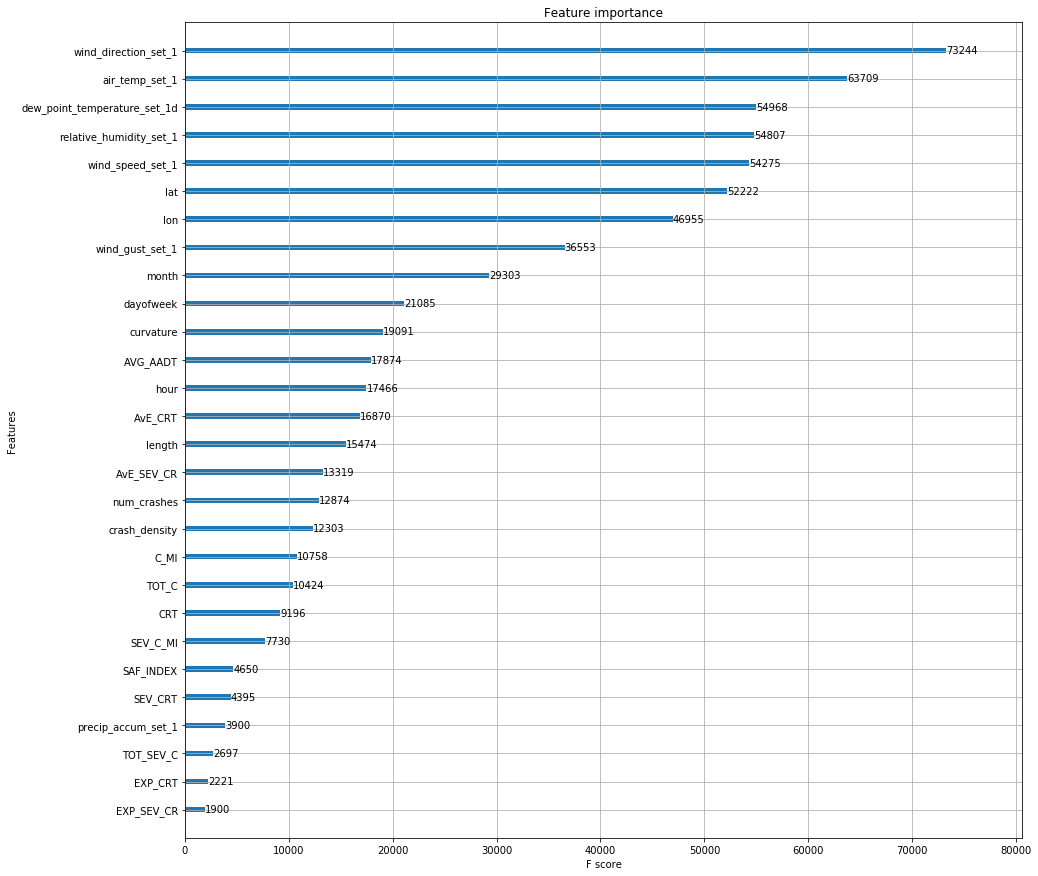

In [54]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster, ax=plt.gca())